# Humans:

Note: for this code to work, the 'data/humans' folder needs to contain one sub-folder for each performed experiment. In each of these folders, the data for the different N values must be contained.

In [8]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.special import ndtr
from scipy.optimize import curve_fit
from scipy.stats import spearmanr, shapiro, ttest_rel, ttest_ind, sem
import seaborn as sns
from cmcrameri import cm
import matplotlib.pyplot as plt
from matplotlib import ticker
from math import sqrt, e
import json

## Pipeline:

In [ ]:
class HumanAnalysisPipeline:
    
    def __init__(self, experiment_name, analysis_type="global", log_scale_K0=False):
        self.experiment_name = experiment_name
        if analysis_type not in ["global", "subject-wise"]:
            raise ValueError("analysis_type must be either 'global' or 'subject-wise'")
        self.analysis_type = analysis_type
        self.log_scale_K0 = log_scale_K0
        
        # Define the path to the experiment directory:
        experiment_path = Path(f'./data/humans/{self.experiment_name}')
        if not experiment_path.exists():
            raise ValueError(f"Experiment directory {experiment_path} does not exist")
        
        # Generate color palettes for global/subject-wise conditions
        # - each folder corresponds to a different N value:
        folders_N_values = [folder for folder in experiment_path.glob('*') if folder.is_dir()]
        self.humans_palette_global = sns.color_palette("flare", len(folders_N_values))
        # - each file inside a single N folder is a different subject: 
        subjects = [file for file in folders_N_values[0].glob('*.csv') if file.is_file()]
        print("Number of subjects for each N value: ", len(subjects))
        self.humans_palette_subjects = sns.color_palette("husl", len(subjects))        
        #NOTE: this color palette assigns the same color to subjects having the same number, possible improvement is setting a different palette for each N value
        
        # Store list of N values in the current experiment (used to loop through all N values)
        self.N_values = [int(folder.name[1:]) for folder in folders_N_values]
                
    
    def read_raw_data(self):
        print("|Reading raw data...")
        
        # Creating an empty dataframe that will be populated with all the data:
        humans_complete_raw_df = pd.DataFrame()

        # Define the path to the experiment directory:
        experiment_path = Path(f'./data/humans/{self.experiment_name}')

        # Accessing all folders in the specified directory (each folder corresponds to a N value):
        folders = experiment_path.glob('*')
                
        for folder in folders:
            if folder.is_dir():
                print(f"||Entered folder: {folder}")
                
                # Accessing all CSV files in the specified directory:
                files = folder.glob('*.csv')
                
                for file_index, file in enumerate(files):
                    if file.is_file():                        
                        try:
                            # Reading the CSV file:
                            df = pd.read_csv(file)

                            # Concatenating the dataframes (NOTE: assigning a subject number to each file)
                            if self.experiment_name == "2023-06_thesis-data":
                                df['subject_number'] = file_index + 1
                            else:
                                #NOTE (to implement): assign Prolific id instead of subject number? Maybe not, subject number assignment is fine
                                raise ValueError("IMPLEMENT PROLIFIC ID ASSIGNMENT")
                                
                            humans_complete_raw_df = pd.concat([humans_complete_raw_df, df], axis=0, ignore_index=True)
                            
                        except Exception as e:
                            print(f"Error reading file {file}: {e}")
                            return
                    else:
                        print(f"File {file} does not exist.")
                        return
        
        self.humans_complete_raw_df = humans_complete_raw_df
                
        print("|Completed reading raw data.")
    
    
    def calculate_demographics(self):
        print("|Calculating demographics.")

        #NOTE: in N-grid experiments, pooling data from all N values, no differentiation between N values in demographics
        
        # isolating survey trials to calculate average age:
        humans_survey = self.humans_complete_raw_df[self.humans_complete_raw_df.trial_type == "survey-html-form"]
        # initializations:
        age = []    # list to store ages
        female_count = 0
        male_count = 0
        transgender_count = 0
        other = 0
        not_specified = 0
        # accessing ages and storing them:
        for index, row in humans_survey.iterrows():            
            try:
                response_dict = json.loads(row.response)
                # appending age to the list:
                age.append(int(response_dict['age']))
                # incrementing gender count:
                match response_dict['gender']:
                    case "female":
                        female_count += 1
                    case "male":
                        male_count += 1
                    case "transgender":
                        transgender_count += 1
                    case "other":
                        other += 1
                    case "not-specified":
                        not_specified += 1
                    case _:
                        return "Other"
                
            except ValueError:
                print(f"Error reading dictionary for row {index}.")                            
        
        # calculating average age and total female count:
        try:
            average_age = np.mean(age)
            print(f"Average age: {average_age}")
        except ZeroDivisionError:
            print("Error calculating average age: No valid age data found")
        
        if self.experiment_name == "2023-06_thesis-data":
            # in thesis data, same subjects performed the experiment at N=300 and N=1000, so we need to divide by 2
            female_count =  female_count / 2
            male_count = male_count / 2    
        print(f"Female count: {female_count}")
        print(f"Male count: {male_count}")
        print(f"Transgender count: {transgender_count}")
        print(f"Other count: {other}")
        print(f"Not specified count: {not_specified}")
        
        print("|Completed calculating demographics.")
            
    
    # def calculate_devices_stats(self):
    #TODO    
     
    def clean_data(self):
        print("|Cleaning data...")
        
        try:
            # cleaning raw data to access only relevant variables:
            # - isolating experiment trials ("canvas-keyboard-response" ones) and dropping irrelevant variables:
            cleaned_df = self.humans_complete_raw_df[self.humans_complete_raw_df.trial_type == "canvas-keyboard-response"]
            # - dropping irrelevant variables:
            cleaned_df = cleaned_df.drop(["timeout","failed_images","failed_audio","failed_video","view_history","trial_index", "time_elapsed","internal_node_id" ,"success","stimulus","graphs_couple"], axis=1).copy()
            
            # excluding trials where response times are <100ms:
            #NOTE: rt<100ms trials are excluded from all analyses 
            cleaned_df_filtered = cleaned_df[cleaned_df['rt'].values >= 100]
            excluded_trials = len(cleaned_df) - len(cleaned_df_filtered)  
            print(f'Excluding {excluded_trials} trials where response time is less than 100ms. {len(cleaned_df_filtered)} trials remaining. Excluded {round((excluded_trials/len(cleaned_df))*100, 2)}% of trials.')

            # differentiating trials:
            # - final responses
            self.cleaned_data_final_resp = cleaned_df_filtered[cleaned_df_filtered['response'].isin(['arrowright','arrowleft'])]
            # - shuffle trials
            self.cleaned_data_shuffles = cleaned_df_filtered[cleaned_df_filtered['response'].isin([' '])]
            # - response times (keeping both shuffles and final responses)
            self.cleaned_data_response_times = cleaned_df_filtered.copy()           

            print(self.cleaned_data_response_times.tail())
            
            # adding control to check that the graph sizes in the experiment folder corresponds to the graph sizes in the cleaned data:
            N_values_cleaned_data = self.cleaned_data_final_resp['graph_size'].unique()
            for N_value_cleaned_data in N_values_cleaned_data:
                if not N_value_cleaned_data in self.N_values:
                    print(f"N value {N_value_cleaned_data} in cleaned data is not present in the list of N values. Check that the data inside the folders corresponds to the N value indicated by the folder name.")
                    return 
            
        except Exception as e:
            print(f"Error cleaning data: {e}")
        
        print("|Completed cleaning data.")
        
        
    def calculate_fraction_correct(self):
        print("|Calculating fraction correct...")
            
        # initializations:
        df_humans_fraction_correct_appended = []
        for N_value in sorted(self.N_values):
            # isolating data of current N value:
            currentN_data = self.cleaned_data_final_resp[self.cleaned_data_final_resp.graph_size == N_value]
            # isolating the single values of K:
            K_range = currentN_data['clique_size'].unique()
            for K_value in K_range:
                if self.analysis_type == "global":
                    # isolating data of current clique size:
                    currentK_data = currentN_data[currentN_data.clique_size == K_value]
                    # calculating accuracy for current clique size ("correct", when present, is either True or False)
                    if self.experiment_name == "2023-06_thesis-data":
                        fraction_correct_currentK = sum(currentK_data.accuracy) / sum(~ currentK_data.accuracy.isna())
                    else:
                        fraction_correct_currentK = sum(currentK_data.correct) / sum(~ currentK_data.correct.isna())
                    # appending data to the list:
                    df_humans_fraction_correct_appended.append(pd.DataFrame({'N':[N_value], 'K':[K_value], 'fc':[fraction_correct_currentK]}))
                elif self.analysis_type == "subject-wise":
                    for subject_number in currentN_data['subject_number'].unique():
                        # isolating data of current clique size and subject number:
                        currentK_data = currentN_data[(currentN_data.clique_size == K_value) & (currentN_data.subject_number == subject_number)]
                        # calculating accuracy ("correct", when present, is either True or False)
                        if self.experiment_name == "2023-06_thesis-data":
                            fraction_correct_currentK = sum(currentK_data.accuracy) / sum(~ currentK_data.accuracy.isna())
                        else:
                            fraction_correct_currentK = sum(currentK_data.correct) / sum(~ currentK_data.correct.isna())
                        # appending data to the list:
                        df_humans_fraction_correct_appended.append(pd.DataFrame({'subject_number':[subject_number],'N':[N_value], 'K':[K_value], 'fc':[fraction_correct_currentK]}))
                else:
                    raise ValueError("Invalid analysis type")

        # creating single df for current N value:   
        df_humans_fraction_correct = pd.concat(df_humans_fraction_correct_appended)
        # creating new variable and adding it to the dataframe:
        df_humans_fraction_correct['K/sqrt(N)'] = df_humans_fraction_correct['K']/np.sqrt(df_humans_fraction_correct['N'])
        # creating new variable and adding it to the dataframe:
        df_humans_fraction_correct['K/N'] = df_humans_fraction_correct['K']/df_humans_fraction_correct['N']
        # saving dataframe:
        self.df_humans_fraction_correct = df_humans_fraction_correct
        # visualizing dataframe:
        display(df_humans_fraction_correct)  
        print("|Completed calculating fraction correct.")      
    
    def generate_boxplot(self):
    # Description:
    # Boxplot to compare the fraction of correct responses at different N values (emerging trend: larger N -> larger fraction correct)  

        print("|Generating boxplot...") 
        
        # creating unique figure (width variable baed on N values):
        fig, ax = plt.subplots(figsize=(3 * len(self.df_humans_fraction_correct['N'].unique()), 4))
                
        ax.set_xlim([80, 1020])
        ax.set_ylim([0.5, 1])        
        
        # creating dataframe containing only data to plot
        average_fc_df = self.df_humans_fraction_correct.groupby(['subject_number', 'N'])['fc'].mean().reset_index()
        
        # swarmplot with single subjects:
        ax = sns.stripplot(data=average_fc_df, x='N', y='fc', hue='subject_number', palette=self.humans_palette_subjects, s=7, alpha=0.7, legend=False)
        # adding corresponding mean value as a point over each swarmplot:
        ax.scatter([str(i) for i in sorted(self.N_values)], average_fc_df.groupby('N')['fc'].mean().values, color=self.humans_palette_global, s=120, marker='o')

        # Generate legend for average points:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=self.humans_palette_global[i], markersize=10) for i in range(len(self.N_values))]
        ax.legend(handles, [f'N = {i}' for i in sorted(self.N_values)], title='Average fraction correct', loc='center left', bbox_to_anchor=(1, 0.5))
                
        ax.set_xlabel('Number of nodes', size=12)
        ax.set_ylabel('Fraction correct', size=12)
        ax.set_title('Fraction correct as a function of N', size=14)
        
        # saving figure in corresponding "plots/humans" folder
        plt.savefig(f'./plots/humans/{self.experiment_name}/humans-boxplot_{self.experiment_name}.svg', dpi=300, bbox_inches="tight")
        plt.savefig(f'./plots/humans/{self.experiment_name}/humans-boxplot_{self.experiment_name}.png', dpi=300, bbox_inches="tight")
       
        plt.show()
        
        print("|Completed generating boxplot.")
        
        
    def calculate_boxplot_stats(self):
        # Description:
        # - comparing mean fraction correct at different N values to check if they differ significantly (emerging trend: larger N -> larger fraction correct).
        # NOTE:
        # 1. this is a global analysis (no subject information)
        # 2. differentiating test based on the number of N values (ANOVA for more than 2 N values, t-test for 2 N values)
        # 3. not creating dataframe, only printing values
        # 4. setting alternative='less' to check for increase in fraction correct for larger N values
        
        # creating dataframe containing only data to analyze
        average_fc_df = self.df_humans_fraction_correct.groupby(['subject_number', 'N'])['fc'].mean().reset_index()        
        
        # calculating mean and standard error of the mean for all N values:
        for N_value in sorted(self.N_values):
            print(f"Mean fraction correct for N = {N_value}: {average_fc_df[average_fc_df['N'] == N_value]['fc'].mean()} +- {sem(average_fc_df[average_fc_df['N'] == N_value]['fc'])}")
        
        # differentiating analysis based on number of N values:
        if len(self.N_values) == 2:
            print("|Calculating boxplot stats (2 N values -> t-test)...")
            # checking t-test assumptions:
            # - normality
            print("Shapiro-Wilk test for normality:")
            print(f"- for {sorted(self.N_values)[0]}: {shapiro(average_fc_df[average_fc_df['N'] == sorted(self.N_values)[0]]['fc'])}")
            print(f"- for {sorted(self.N_values)[1]}: {shapiro(average_fc_df[average_fc_df['N'] == sorted(self.N_values)[1]]['fc'])}")                        
            # performing t-test:            
            if self.experiment_name == "2023-06_thesis-data":
                print("thesis data")
                # in the thesis data, the two samples are dependent (same subjects)
                t_test_stat = ttest_rel(average_fc_df[average_fc_df['N'] == sorted(self.N_values)[0]]['fc'], average_fc_df[average_fc_df['N'] == sorted(self.N_values)[1]]['fc'], alternative='less')
            else:
                # in general, the two samples are independent (different subjects)
                t_test_stat = ttest_ind(average_fc_df[average_fc_df['N'] == sorted(self.N_values)[0]]['fc'], average_fc_df[average_fc_df['N'] == sorted(self.N_values)[1]]['fc'], alternative='less')
            # printing t-test results 
            print(f"t-statistic: {t_test_stat.statistic}, p-value: {t_test_stat.pvalue}")            
                 
        elif len(self.N_values) > 2:
            print("|Calculating boxplot stats (more than 2 N values -> ANOVA)...")
            #TODO: implement ANOVA test
            # checking ANOVA assumptions:
            
            # performing ANOVA test:

            # adding stats to pipeline / printing results

        else:
            raise ValueError("Only one N value, cannot perform statistical test")
                
            
    def calculate_fitted_params(self):
        print("|Calculating fitted parameters...")
        
        def sigmoid(k, k0, delta):
            return (1+ndtr((k-k0)/delta))/2 
        
        # empty dataframe where fitted parameters will be stored:
        df_humans_fitted_params_appended = []
        
        # looping through all N values:
        for N_value in sorted(self.N_values):
            # selecting trials for current N value:
            current_data = self.df_humans_fraction_correct[self.df_humans_fraction_correct['N']==N_value]
            if self.analysis_type == "global":
                # calculating fitted parameters:
                fitted_params = curve_fit(sigmoid, current_data['K'], current_data['fc'], p0=(70, 20))[0]
                # adding fitted parameters to the dataframe (K0 and Delta):
                df_humans_fitted_params_appended.append(pd.DataFrame({'N': [N_value], 'K0':[fitted_params[0]], 'Delta':[fitted_params[1]]}))
            elif self.analysis_type == "subject-wise":
                # looping through all subjects for current N value:
                for subject in current_data['subject_number'].unique():
                    # accessing data for current subject:
                    current_subject_data = current_data[current_data['subject_number'] == subject]
                    # calculating fitted parameters:
                    fitted_params = curve_fit(sigmoid, current_subject_data['K'], current_subject_data['fc'], p0=(70, 20))[0]
                    # adding fitted parameters to the dataframe:
                    df_humans_fitted_params_appended.append(pd.DataFrame({'subject_number':[subject], 'N': [N_value], 'K0':[fitted_params[0]], 'Delta':[fitted_params[1]]}))

        # concatenating dataframe of fitted parameters:
        df_humans_fitted_params = pd.concat(df_humans_fitted_params_appended)
        # saving dataframe:
        self.df_humans_fitted_params = df_humans_fitted_params
        # visualizing dataframe:
        display(df_humans_fitted_params)
        print("|Completed calculating fitted parameters.")
    
    
    def generate_psychometrics(self):
        print("|Generating psychometric curves...")
        
        # defining x values:
        x_vals = np.linspace(0, 0.4*max(self.df_humans_fraction_correct['N'].unique()), 1000)       
        
        # DRAWING THE PSYCHOMETRIC CURVES
        if self.analysis_type == "global":
            fig, ax = plt.subplots(1, 2, figsize=(9, 4))
            # - two subplots showing the global psychometric curves. The one on the left shows K on x-axis, the one on the right shows K/N on x-axis.
            # - K on x-axis:
            sns.scatterplot(data=self.df_humans_fraction_correct, x='K', y='fc', ax=ax[0], s=10, hue='N', palette=self.humans_palette_global)
            # - K/N on x-axis:
            sns.scatterplot(data=self.df_humans_fraction_correct, x='K/N', y='fc', ax=ax[1], s=10, hue='N', palette=self.humans_palette_global)
            for i, N_value in enumerate(sorted(self.N_values)):
                # defining y values for the psychometric curve: 
                k0 = self.df_humans_fitted_params[(self.df_humans_fitted_params['N'] == N_value)]['K0'].values[0]
                delta = self.df_humans_fitted_params[(self.df_humans_fitted_params['N'] == N_value)]['Delta'].values[0]
                y_vals = (1 + ndtr((x_vals - k0) / delta)) / 2
                # creating dataframe to plot the line using seaborn:
                df_line = pd.DataFrame({'N': N_value, 'K': x_vals, 'fc': y_vals})
                df_line['K/N'] = df_line['K']/df_line['N']
                # plotting the psychometric curve:
                sns.lineplot(data=df_line, x='K', y='fc', ax=ax[0], color=self.humans_palette_global[i])  
                sns.lineplot(data=df_line, x='K/N', y='fc', ax=ax[1], color=self.humans_palette_global[i])                          
            
            ax[0].set_ylabel("Fraction correct")
            ax[0].set_xlabel("Clique size")
            ax[0].tick_params(axis='x')
            ax[0].tick_params(axis='y')
            ax[0].set_title("Psychometric curves (K on x-axis)")
            ax[1].set_ylabel("Fraction correct")
            ax[1].set_xlabel("Clique size / N")
            ax[1].set_xlim(ax[1].get_xlim()[0], 0.6)
            ax[1].tick_params(axis='x')
            ax[1].tick_params(axis='y')
            ax[1].set_title("Psychometric curves (K/N on x-axis)") 
            
            # adjusting layout and saving figure:
            plt.tight_layout()
            # saving figure in corresponding "plots/humans" folder       
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-psychometric-curves_{self.experiment_name}_global.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-psychometric-curves_{self.experiment_name}_global.png', dpi=300, bbox_inches="tight")  
                
        elif self.analysis_type == "subject-wise":     
            # - create subplots based on the number of N values and subjects:
            n_values = len(self.df_humans_fraction_correct['N'].unique())
            subjects = len(self.df_humans_fraction_correct['subject_number'].unique())    
            fig, ax = plt.subplots(n_values, subjects, figsize=(5 * subjects, 4 * n_values), constrained_layout=True)

            # - loop through the N values:
            for i, N_value in enumerate(sorted(self.N_values)):
                # isolating data for current N value:
                current_data = self.df_humans_fraction_correct[self.df_humans_fraction_correct['N'] == N_value]
        
                # defining y values and plotting the scatterplot and the psychometric curve:
                for j, subject_number in enumerate(current_data['subject_number'].unique()):
                    # drawing scatterplot based on fraction correct dataframe:
                    subject_data = current_data[current_data['subject_number'] == subject_number]
                    sns.scatterplot(data=subject_data, x='K', y='fc', color=self.humans_palette_subjects[j], ax=ax[i, j], s=10)
                    # defining y values and plotting the psychometric curve:
                    k0 = self.df_humans_fitted_params[(self.df_humans_fitted_params['N'] == N_value) & (self.df_humans_fitted_params['subject_number'] == subject_number)]['K0'].values[0]
                    delta = self.df_humans_fitted_params[(self.df_humans_fitted_params['N'] == N_value) & (self.df_humans_fitted_params['subject_number'] == subject_number)]['Delta'].values[0]
                    y_vals = (1 + ndtr((x_vals - k0) / delta)) / 2
                    ax[i, j].plot(x_vals, y_vals, color=self.humans_palette_subjects[j], label=f'Subject {subject_number}')
                    ax[i, j].set_ylabel("Fraction correct")
                    ax[i, j].set_xlabel("Clique size")    
                    ax[i, j].tick_params(axis='x')
                    ax[i, j].tick_params(axis='y')
                    ax[i, j].set_title(f"N = {int(N_value)}, Subject {subject_number}")

            # adjusting layout and saving figure:
            plt.tight_layout()
            # saving figure in corresponding "plots/humans" folder
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-psychometric-curves_{self.experiment_name}_subjects.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-psychometric-curves_{self.experiment_name}_subjects.png', dpi=300, bbox_inches="tight")
                                         
        else:
            raise ValueError("Invalid analysis type")
              
         
        # Show the plot
        plt.show()
    
        print("|Completed generating psychometric curves.")
        
        
    def calculate_shuffles_df(self):
        print("|Calculating shuffles dataframe...")
        
        # initializations:
        df_humans_mean_shuffles_appended = []
        
        # retrieving the number of trials for a given clique size value in the whole experiment (used to normalize the number of shuffles):
        N_trials_per_K_value = self.cleaned_data_final_resp.groupby(['graph_size', 'clique_size', 'subject_number']).size().reset_index(name='count')
        print("Number of trials per clique size in the whole exp:", N_trials_per_K_value['count'].iloc[0])
        
        # looping through all N values, clique size values and subjects
        for N_value in sorted(self.N_values):
            currentN_data = self.cleaned_data_final_resp[self.cleaned_data_final_resp.graph_size == N_value]
            # looping through all K values for current N value:
            for K_value in currentN_data['clique_size'].unique():
                currentK_data = currentN_data[currentN_data.clique_size == K_value]
                # looping through all subjects for current N and K values:
                for subject_number in currentK_data['subject_number'].unique():
                    # isolating data of current N value, K value and subject number (NOTE: using self.cleaned_data_shuffles here)
                    currentK_subject_shuffles = self.cleaned_data_shuffles[(self.cleaned_data_shuffles.graph_size == N_value) & (self.cleaned_data_shuffles.clique_size == K_value) & (self.cleaned_data_shuffles.subject_number == subject_number)]
                    # counting the number of shuffles for current subject for current N and K values:
                    mean_shuffles_subject = len(currentK_subject_shuffles) / N_trials_per_K_value['count'].iloc[0]  # normalizing by the number of trials for a given clique size value in the whole experiment
                    # appending data to the list:
                    df_humans_mean_shuffles_appended.append(pd.DataFrame({'subject_number':[subject_number],'N':[N_value], 'K': [K_value], 'mean_shuffles':[mean_shuffles_subject]}))

        # creating single df:   
        df_humans_shuffles = pd.concat(df_humans_mean_shuffles_appended)
        # creating new variable and adding it to the dataframe:
        df_humans_shuffles['K/N'] = df_humans_shuffles['K']/df_humans_shuffles['N']
        # saving dataframe:
        self.df_humans_shuffles = df_humans_shuffles
        # visualizing dataframe:
        display(self.df_humans_shuffles)  
                
        print("|Completed calculating shuffles dataframe.")
        
    
    def generate_shuffles_graphs(self):
        
        print("|Generating shuffles graphs...")

        if self.analysis_type == "global":                    
            fig, ax = plt.subplots(1, 2, figsize=(9, 4))
            # - K on x-axis:
            sns.lineplot(data = self.df_humans_shuffles, x = 'K', y = 'mean_shuffles', hue='N', palette=self.humans_palette_global, errorbar='se', linestyle='-', marker='o', ax=ax[0])
            # - K/N on x-axis:
            sns.lineplot(data = self.df_humans_shuffles, x = 'K/N', y = 'mean_shuffles', hue='N', palette=self.humans_palette_global, errorbar='se', linestyle='-', marker='o', ax=ax[1])

            # plotting K0s as vertical red dashed lines:
            for i, N_value in enumerate(sorted(self.N_values)):
                K0 = self.df_humans_fitted_params[self.df_humans_fitted_params['N'] == N_value]['K0'].values[0]
                ax[0].axvline(K0, color=self.humans_palette_global[i], linestyle='--', linewidth=1.5)
                # adding label to K0 line at the top of the figure, increasing size of text:
                ax[0].text(K0+0.5, 3, 'K₀', color=self.humans_palette_global[i], ha='left', va='top', fontsize=15)
                ax[1].axvline(K0/N_value, color=self.humans_palette_global[i], linestyle='--', linewidth=1.5)
                # adding label to K0 line at the top of the figure, increasing size of text:
                ax[1].text(K0/N_value+0.005, 3, 'K₀', color=self.humans_palette_global[i], ha='left', va='top', fontsize=15)
            
                # setting labels and title:
                ax[0].set_xlim(ax[0].get_xlim()[0], 320)
                ax[0].set_ylim(-0.5, 4)
                ax[0].set_ylabel("Number of shuffles")
                ax[0].set_xlabel("Clique size")
                ax[0].tick_params(axis='x')
                ax[0].tick_params(axis='y')
                ax[0].set_title("Number of shuffles as a function of K")
                ax[1].set_xlim(ax[1].get_xlim()[0], 0.3)
                ax[1].set_ylim(-0.5, 4)
                ax[1].set_ylabel("Number of shuffles")
                ax[1].set_xlabel("Clique size / N")
                ax[1].tick_params(axis='x')
                ax[1].tick_params(axis='y')
                ax[1].set_title("Number of shuffles as a function of K / N")
                
                # adjusting layout and saving figure:
                plt.tight_layout()
                plt.subplots_adjust(wspace=0.5)
                
                # saving figure in corresponding "plots/humans" folder
                plt.savefig(f'./plots/humans/{self.experiment_name}/humans-shuffles-graphs_{self.experiment_name}_global.svg', dpi=300, bbox_inches="tight")
                plt.savefig(f'./plots/humans/{self.experiment_name}/humans-shuffles-graphs_{self.experiment_name}_global.png', dpi=300, bbox_inches="tight")
        
        elif self.analysis_type == "subject-wise":            
            
            # creating one subplot for each N value:
            fig, axes = plt.subplots(nrows=len(self.df_humans_fitted_params['N'].unique()), ncols=1, figsize=(7, 8))
            
            # - loop through the N values:        
            for i, N_value in enumerate(sorted(self.N_values)):
                # isolating data for current N value:
                currentN_shuffles = self.df_humans_shuffles[self.df_humans_shuffles['N'] == N_value]
                ax = axes[i]
                sns.lineplot(data=currentN_shuffles, x='K', y='mean_shuffles', hue='subject_number', palette=self.humans_palette_subjects, legend=False, linewidth=1, marker='o', linestyle='--', ax=ax)
                # calculating the mean number of shuffles for current N value across all subjects:
                mean_shuffles = currentN_shuffles.groupby('K')['mean_shuffles'].mean()
                # create dataframe of mean number of shuffles to use seaborn, using .index and .values:
                mean_df = pd.DataFrame({'clique_size': mean_shuffles.index, 'mean_shuffles': mean_shuffles.values})
                # Plotting the mean number of shuffles as a red line with dots as markers
                sns.lineplot(data = mean_df, x = 'clique_size', y = 'mean_shuffles', color=self.humans_palette_global[i], markersize=10, linewidth=2, marker='o', ax=ax, label='Average')
                # calculating mean K0 value for current N value:
                K0_value = self.df_humans_fitted_params[self.df_humans_fitted_params['N'] == N_value]['K0'].mean()
                
                print(f"Mean K0 value for N = {N_value}: {K0_value}")
                
                # plotting vertical red dashed line for K0:
                ax.axvline(K0_value, color=self.humans_palette_global[i], linestyle='--', linewidth=2)
                # adding label to K0 line at the top of the figure, increasing size of text:
                ax.text(K0_value, 3, 'K₀', color=self.humans_palette_global[i], ha='left', va='top', fontsize=15)
                
                # setting labels and title:
                ax.set_xlabel('Clique size')
                ax.set_ylabel('Number of shuffles')
                ax.set_title(f'Number of shuffles as a function of clique size (N = {N_value})')
                ax.tick_params(axis='x')
                ax.tick_params(axis='y')
        
            # adjusting layout and saving figure:
            plt.tight_layout()        
            plt.subplots_adjust(hspace=0.5)    
        
            # saving figure in corresponding "plots/humans" folder
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-shuffles-graphs_{self.experiment_name}_subjects.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-shuffles-graphs_{self.experiment_name}_subjects.png', dpi=300, bbox_inches="tight")
                              
        else:
            raise ValueError("Invalid analysis type")    

        # Show the plot
        plt.show()
    
    def calculate_shuffles_stats(self):
        print("|Calculating shuffles stats...")
        
        # Description:
        # - calculating Spearman correlation to check if the number of shuffles is correlated with the clique size value (K).
        # NOTE: in this case, no differentiation between global and subject-wise analysis
        
        # initialization:
        df_humans_shuffles_stats_appended = []
        # - isolating data for each N value:
        for i, N_value in enumerate(sorted(self.N_values)):
            print(f"Calculating shuffles stats for N = {N_value}")
            currentN_shuffles = self.df_humans_shuffles[self.df_humans_shuffles['N'] == N_value]
            shuffles_stat = spearmanr(currentN_shuffles['mean_shuffles'], currentN_shuffles['K'], alternative='less')
            print(f"Spearman correlation coefficient for N = {N_value}: {shuffles_stat.correlation}")
            print(f"P-value for N = {N_value}: {shuffles_stat.pvalue}")
            df_humans_shuffles_stats_appended.append(pd.DataFrame({'N': [N_value], 'correlation':[shuffles_stat.correlation], 'p-value':[shuffles_stat.pvalue]}))
        # creating single df:
        df_humans_shuffles_stats = pd.concat(df_humans_shuffles_stats_appended)
        self.df_humans_shuffles_stats = df_humans_shuffles_stats
        display(df_humans_shuffles_stats)
        
        print("|Completed calculating shuffles stats.")
    
    
    def calculate_response_times_df(self):
        print("|Calculating response times dataframe...")
        
        # initializations:
        df_humans_mean_response_times_appended = []
        
        # looping through all N values, clique size values and subjects
        for N_value in sorted(self.N_values):
            currentN_data = self.cleaned_data_response_times[self.cleaned_data_response_times.graph_size == N_value]
            # looping through all K values for current N value:
            for K_value in currentN_data['clique_size'].unique():
                currentK_data = currentN_data[currentN_data.clique_size == K_value]
                # looping through all subjects for current N and K values:
                for subject_number in currentK_data['subject_number'].unique():
                    # isolating data of current N value, K value and subject number
                    currentK_subject_response_times = self.cleaned_data_response_times[(self.cleaned_data_response_times.graph_size == N_value) & (self.cleaned_data_response_times.clique_size == K_value) & (self.cleaned_data_response_times.subject_number == subject_number)]
                    # calculating mean response times for current subject for current N and K values (converting to seconds):
                    mean_response_times_subject = currentK_subject_response_times['rt'].mean() / 1000
                    # appending data to the list:
                    df_humans_mean_response_times_appended.append(pd.DataFrame({'subject_number':[subject_number],'N':[N_value], 'K': [K_value], 'mean_resp_time':[mean_response_times_subject]}))

        # creating single df:   
        df_humans_response_times = pd.concat(df_humans_mean_response_times_appended)
        # creating new variable and adding it to the dataframe:
        df_humans_response_times['K/N'] = df_humans_response_times['K']/df_humans_response_times['N']
        # saving dataframe:
        self.df_humans_response_times = df_humans_response_times
        # visualizing dataframe:
        display(self.df_humans_response_times)  
                
        print("|Completed calculating response times dataframe.")
        
    
    def generate_response_times_graphs(self):
        
        print("|Generating response times graphs...")

        if self.analysis_type == "global":                    
            fig, ax = plt.subplots(1, 2, figsize=(10, 4))
            # - K on x-axis:
            sns.lineplot(data = self.df_humans_response_times, x = 'K', y = 'mean_resp_time', hue='N', palette=self.humans_palette_global, errorbar='se', linestyle='-', marker='o', ax=ax[0])
            # - K/N on x-axis:
            sns.lineplot(data = self.df_humans_response_times, x = 'K/N', y = 'mean_resp_time', hue='N', palette=self.humans_palette_global, errorbar='se', linestyle='-', marker='o', ax=ax[1])

            # plotting K0s as vertical red dashed lines:
            for i, N_value in enumerate(sorted(self.N_values)):
                K0 = self.df_humans_fitted_params[self.df_humans_fitted_params['N'] == N_value]['K0'].values[0]
                ax[0].axvline(K0, color=self.humans_palette_global[i], linestyle='--', linewidth=1.5)
                # adding label to K0 line at the top of the figure, increasing size of text:
                ax[0].text(K0+5, 3.8, 'K₀', color=self.humans_palette_global[i], ha='left', va='top', fontsize=15)
                ax[1].axvline(K0/N_value, color=self.humans_palette_global[i], linestyle='--', linewidth=1.5)
                # adding label to K0 line at the top of the figure, increasing size of text:
                ax[1].text(K0/N_value+0.005, 3.8, 'K₀', color=self.humans_palette_global[i], ha='left', va='top', fontsize=15)
            
                # setting labels and title:
                ax[0].set_xlim(ax[0].get_xlim()[0], 320)
                ax[0].set_ylabel("Response time (s, log-scaled)")
                ax[0].set_xlabel("Clique size")
                ax[0].tick_params(axis='x')
                ax[0].tick_params(axis='y')
                ax[0].set_title("Response time as a function of K")
                ax[1].set_xlim(ax[1].get_xlim()[0], 0.3)
                ax[1].set_ylabel("Response time (s, log-scaled)")
                ax[1].set_xlabel("Clique size / N")
                ax[1].tick_params(axis='x')
                ax[1].tick_params(axis='y')
                ax[1].set_title("Response time as a function of K / N")
                
                # Log-scaling the y-axis  
                ax[0].set_yscale('log', base=2)
                # Using ScalarFormatter to format the y-axis with actual numbers instead of powers of 2
                ax[0].yaxis.set_major_formatter(ticker.ScalarFormatter())
                ax[0].autoscale()      
                # Log-scaling the y-axis  
                ax[1].set_yscale('log', base=2)
                # Using ScalarFormatter to format the y-axis with actual numbers instead of powers of 2
                ax[1].yaxis.set_major_formatter(ticker.ScalarFormatter())
                ax[1].autoscale()                                
                
                # adjusting layout and saving figure:
                # plt.tight_layout()
                plt.subplots_adjust(wspace=0.6)
                
                # saving figure in corresponding "plots/humans" folder
                plt.savefig(f'./plots/humans/{self.experiment_name}/humans-response-times-graphs_{self.experiment_name}_global.svg', dpi=300, bbox_inches="tight")
                plt.savefig(f'./plots/humans/{self.experiment_name}/humans-response-times-graphs_{self.experiment_name}_global.png', dpi=300, bbox_inches="tight")
        
        elif self.analysis_type == "subject-wise":            
            
            # creating one subplot for each N value:
            fig, axes = plt.subplots(nrows=len(self.N_values), ncols=1, figsize=(10, 8))
            
            # - loop through the N values:        
            for i, N_value in enumerate(sorted(self.N_values)):
                # isolating data for current N value:
                currentN_resp_times = self.df_humans_response_times[self.df_humans_response_times['N'] == N_value]
                ax = axes[i]
                sns.lineplot(data=currentN_resp_times, x='K', y='mean_resp_time', hue='subject_number', palette=self.humans_palette_subjects, legend=False, linewidth=1, marker='o', linestyle='--', ax=ax)
                # calculating the mean response time for current N value across all subjects:
                mean_resp_time = currentN_resp_times.groupby('K')['mean_resp_time'].mean()
                # create dataframe of mean response time to use seaborn, using .index and .values:
                mean_df = pd.DataFrame({'clique_size': mean_resp_time.index, 'mean_resp_time': mean_resp_time.values})
                # Plotting the mean response time as a red line with dots as markers
                sns.lineplot(data = mean_df, x = 'clique_size', y = 'mean_resp_time', color=self.humans_palette_global[i], markersize=10, linewidth=2, marker='o', ax=ax, label='Average')
                # calculating mean K0 value for current N value:
                K0_value = self.df_humans_fitted_params[self.df_humans_fitted_params['N'] == N_value]['K0'].mean()
                
                # plotting vertical red dashed line for K0:
                ax.axvline(K0_value, color=self.humans_palette_global[i], linestyle='--', linewidth=2)
                # adding label to K0 line at the top of the figure, increasing size of text:
                ax.text(K0_value+1, 8, 'K₀', color=self.humans_palette_global[i], ha='left', va='top', fontsize=15)
                
                # setting labels and title:
                ax.set_xlabel('Clique size')
                ax.set_ylabel('Response time (s, log-scaled)')
                ax.set_title(f'Response time as a function of clique size (N = {N_value})')
                ax.tick_params(axis='x')
                ax.tick_params(axis='y')
        
                # Log-scaling the y-axis  
                ax.set_yscale('log', base=2)
                ax.set_ylim(0, *ax.get_ylim()[1:])
                # Using ScalarFormatter to format the y-axis with actual numbers instead of powers of 2
                ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
                ax.autoscale()      
                        
            # adjusting layout and saving figure:
            plt.tight_layout()        
            plt.subplots_adjust(hspace=0.6)    
        
            # saving figure in corresponding "plots/humans" folder
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-response-times-graphs_{self.experiment_name}_subjects.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-response-times-graphs_{self.experiment_name}_subjects.png', dpi=300, bbox_inches="tight")
                              
        else:
            raise ValueError("Invalid analysis type")    

        # Show the plot
        plt.show()
    
        print("|Completed generating response times graphs.")
    
    
    def calculate_response_times_stats(self):
        print("|Calculating response times stats...")
        
        # Description:
        # - t-test to check if response times are significantly larger for K value closest to K0 than for the smallest K value.
        # NOTE:
        # 1. in this case, no differentiation between global and subject-wise analysis
        # 2. assuming a large sample size (n > 30) and checking for normality of the data
        
        # function to find the K value that is closer to K0:
        def find_closest_Kvalue(arr, target):
            closest_value = arr[0]  # Initialize with the first element
            min_difference = abs(target - arr[0])  # Initialize with the difference to the first element
            
            # every time a closer element is found, the closest value is updated
            for element in arr:
                difference = abs(target - element)
                if difference < min_difference:
                    min_difference = difference
                    closest_value = element
            
            return closest_value            
        
        # initialization:
        df_humans_response_times_stats_appended = []
        # - isolating data for each N value:
        for i, N_value in enumerate(sorted(self.N_values)):
            print(f"Calculating response time stats for N = {N_value}")
            currentN_response_times = self.df_humans_response_times[self.df_humans_response_times['N'] == N_value]
            # isolating data for the smallest K value:
            smallest_K_value = currentN_response_times['K'].min()
            # isolating data for the K value closest to K0:
            closest_K_value = find_closest_Kvalue(currentN_response_times['K'].unique(), self.df_humans_fitted_params[self.df_humans_fitted_params['N'] == N_value]['K0'].mean())
            # means and SEMs:
            print(f"Mean response times for smallest K value: {currentN_response_times[currentN_response_times['K'] == smallest_K_value]['mean_resp_time'].mean()} +- {sem(currentN_response_times[currentN_response_times['K'] == smallest_K_value]['mean_resp_time'])}")
            print(f"Mean response times for closest K value: {currentN_response_times[currentN_response_times['K'] == closest_K_value]['mean_resp_time'].mean()} +- {sem(currentN_response_times[currentN_response_times['K'] == closest_K_value]['mean_resp_time'])}")
            # checking for normality:
            print("Shapiro-Wilk test for normality:")
            print(f"- for smallest K value: {shapiro(currentN_response_times[currentN_response_times['K'] == smallest_K_value]['mean_resp_time'])}")
            print(f"- for closest K value: {shapiro(currentN_response_times[currentN_response_times['K'] == closest_K_value]['mean_resp_time'])}")
            # performing t-test:
            t_test_stat = ttest_rel(currentN_response_times[currentN_response_times['K'] == closest_K_value]['mean_resp_time'], currentN_response_times[currentN_response_times['K'] == smallest_K_value]['mean_resp_time'], alternative='greater')
            print(f"t-test for N = {N_value}: {t_test_stat}")
            df_humans_response_times_stats_appended.append(pd.DataFrame({'N': [N_value], 't-statistic':[t_test_stat.statistic], 'p-value':[t_test_stat.pvalue]}))
        # creating single df:
        df_humans_response_times_stats = pd.concat(df_humans_response_times_stats_appended)
        self.df_humans_response_times_stats = df_humans_response_times_stats
        display(df_humans_response_times_stats)
        
        print("|Completed calculating response times stats.")


    def explore_visual_strategy(self):
        
    # - set-up pipeline for retrieving graph names from: C:\Users\danie\Desktop\HUPLACLIP-humans\output_check\Output_check_CSV.ipynb
    # - copy graph pool without synching it with GitHub
    
    
    def generate_main_plot(self):
        
        print("|Generating main plot...")
        
        # Create a smaller figure with specified size
        fig, ax = plt.subplots(figsize=(8, 6))  
        
        # - loop through the N values:
        for i, N_value in enumerate(sorted(self.df_humans_fitted_params['N'].unique())):
            # isolating data for current N value:
            current_fitted_params = self.df_humans_fitted_params[self.df_humans_fitted_params['N'] == N_value]
            if self.analysis_type == "global":
                ax.scatter(N_value, current_fitted_params[current_fitted_params['N'] == N_value]['K0'].mean(), label=f'Humans ({N_value})', color=self.humans_palette_global[i], s=120, marker="^")

            elif self.analysis_type == "subject-wise":
                # palette_subjects = sns.color_palette("husl", len(current_fitted_params['subject_number'].unique()))
                ax_humans = sns.scatterplot(data=current_fitted_params, x='N', y='K0', hue='subject_number', palette=self.humans_palette_subjects, legend=False, alpha=0.4, s=70, marker="^")
                ax_humans.scatter(N_value, current_fitted_params[current_fitted_params['N'] == N_value]['K0'].mean(), label=f'Humans ({N_value})', color=self.humans_palette_global[i], s=120, marker="^")

        # THEORETICAL AND COMPUTATIONAL LIMITS:
        N = np.arange(0.1, 1200)
        K_it = 2 * np.log2(N)
        K_comp = np.sqrt(N / np.e)            
        limits_palette = ['green', 'orange']
        ax.plot(N, K_it, label='STAT limit', color=limits_palette[0])
        ax.plot(N[:1125], K_comp[:1125], label='COMP limit', color=limits_palette[1], linestyle='dotted')
        ax.plot(N[1125:], K_comp[1125:], color=limits_palette[1])

        # Add axes labels to the plot
        ax.set_xlabel('Number of nodes', size=12)
        ax.set_ylabel('K₀ (clique detection threshold)', size=12)

        # Log scale for y-axis:
        if self.log_scale_K0:
            ax.set_yscale('log', base=2)
            ax.set_xlim(60, *ax.get_xlim()[1:])
            ax.set_ylim(15, *ax.get_ylim()[1:])
            # Using ScalarFormatter to format the y-axis with actual numbers instead of powers of 2
            ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        else:
            ax.autoscale()      

        # # Drawing linear fit of machines' K0s with points' color gradient
        # TODO: perform linear fit on mean values of K0 for humans? In another function?
        # y_values = slope * N + intercept
        # ax.plot(N, y_values, color=my_palette_rudy[1], linestyle='--')
              
        # Customize legend:
        # Customize legend:
        # handles, labels = ax.get_legend_handles_labels()

        # print(handles)
        # print(labels)

        # filtered_handles = []
        # filtered_labels = []

        # # List of labels you want to keep in the legend
        # labels_to_keep = df_checkpoint_fitted_params['model'].values

        # for handle, label in zip(handles, labels):
        #     if label in labels_to_keep:
        #         filtered_handles.append(handle)
        #         filtered_labels.append(label)

        # # Add a custom legend with only the desired elements
        # ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Agents (Number of nodes):')        
        ax.tick_params(axis='x')
        ax.tick_params(axis='y')
        
        # Set title:
        ax.set_title('Humans: K₀ as a function of N', size=14)
                
        # saving figure in corresponding "plots/humans" folder
        if self.analysis_type == "global":
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-main-plot_{self.experiment_name}_global{"_log-scaled" if self.log_scale_K0 else ""}.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-main-plot_{self.experiment_name}_global{"_log-scaled" if self.log_scale_K0 else ""}.png', dpi=300, bbox_inches="tight")  
        elif self.analysis_type == "subject-wise":
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-main-plot_{self.experiment_name}_subjects{"_log-scaled" if self.log_scale_K0 else ""}.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/humans/{self.experiment_name}/humans-main-plot_{self.experiment_name}_subjects{"_log-scaled" if self.log_scale_K0 else ""}.png', dpi=300, bbox_inches="tight")
                         
        plt.show()
        
        print("|Completed generating main plot.")    
        
        
# Defining subclasses for each analysis type:
    def fitted_params_humans(self):
        self.read_raw_data()
        self.clean_data()
        self.calculate_fraction_correct()
        self.calculate_fitted_params()
        return self.df_humans_fitted_params, self.humans_palette_global    
    
    def shuffles_humans(self):
        self.read_raw_data()
        self.clean_data()
        self.calculate_fraction_correct()
        self.calculate_fitted_params()        
        self.calculate_shuffles_df() 
        self.generate_shuffles_graphs()   
        self.calculate_shuffles_stats()
        
    def response_times_humans(self):
        self.read_raw_data()
        self.clean_data()
        self.calculate_fraction_correct()
        self.calculate_fitted_params()
        self.calculate_response_times_df()
        self.generate_response_times_graphs()
        self.calculate_response_times_stats()
        
    # def strategy_humans(self):
        
    def complete_human_pipeline(self):
        self.read_raw_data()
        self.calculate_demographics()
        self.clean_data()
        self.calculate_fraction_correct()
        self.generate_boxplot()  
        self.calculate_boxplot_stats()   
        self.calculate_fitted_params()
        self.generate_psychometrics()
        self.calculate_shuffles_df()  
        self.generate_shuffles_graphs()
        self.calculate_shuffles_stats()
        self.calculate_response_times_df()
        self.generate_response_times_graphs()
        self.calculate_response_times_stats()        
        self.generate_main_plot()

## Run pipeline:

Number of subjects for each N value:  15
|Reading raw data...
||Entered folder: data\humans\2023-06_thesis-data\N1000


||Entered folder: data\humans\2023-06_thesis-data\N300
|Completed reading raw data.
|Calculating demographics.
Average age: 25.733333333333334
Female count: 11.0
Male count: 4.0
Transgender count: 0
Other count: 0
Not specified count: 0
|Completed calculating demographics.
|Cleaning data...
Excluding 289 trials where response time is less than 100ms. 12318 trials remaining. Excluded 2.29% of trials.
                     trial_type     rt    response  \
26867  canvas-keyboard-response  681.0               
26871  canvas-keyboard-response  429.0               
26873  canvas-keyboard-response  435.0               
26875  canvas-keyboard-response  215.0               
26877  canvas-keyboard-response  173.0  arrowright   

                                             nodes_order correct_response  \
26867  [73,121,176,55,167,262,151,140,172,245,183,178...        arrowleft   
26871  [26,122,7,191,116,196,259,277,283,58,109,24,25...        arrowleft   
26873  [185,269,45,250,90,258,248,216,179

,subject_number,N,K,fc,K/sqrt(N),K/N
0,1,300,90.0,1.0,5.196152,0.3
0,2,300,90.0,1.0,5.196152,0.3
0,3,300,90.0,1.0,5.196152,0.3
0,4,300,90.0,1.0,5.196152,0.3
0,5,300,90.0,1.0,5.196152,0.3
...,...,...,...,...,...,...
0,11,1000,300.0,1.0,9.486833,0.3
0,12,1000,300.0,1.0,9.486833,0.3
0,13,1000,300.0,1.0,9.486833,0.3
0,14,1000,300.0,1.0,9.486833,0.3


|Completed calculating fraction correct.
|Generating boxplot...


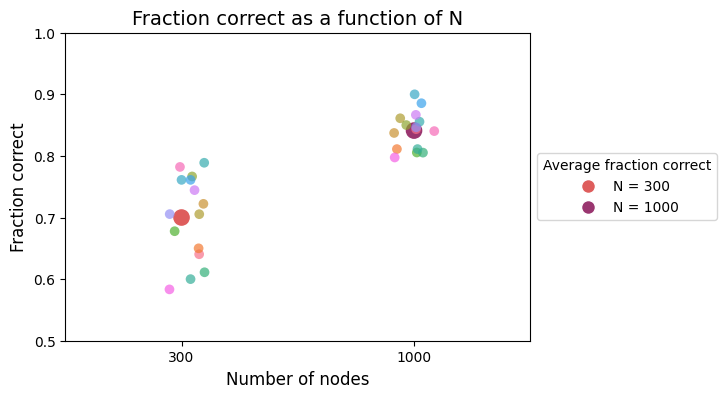

|Completed generating boxplot.
Mean fraction correct for N = 300: 0.7000112233445566 +- 0.017881347495780287
Mean fraction correct for N = 1000: 0.8411380471380472 +- 0.007892770529574957
|Calculating boxplot stats (2 N values -> t-test)...
Shapiro-Wilk test for normality:
- for 300: ShapiroResult(statistic=np.float64(0.9247971764546752), pvalue=np.float64(0.22785516278393436))
- for 1000: ShapiroResult(statistic=np.float64(0.9480629968115557), pvalue=np.float64(0.49447723864767446))
thesis data
t-statistic: -10.971642165844354, p-value: 1.4638710965326634e-08


In [31]:
# Instantiate the pipeline with the experiment name
human_pipeline = HumanAnalysisPipeline(experiment_name="2023-06_thesis-data", analysis_type="subject-wise", log_scale_K0=True)

# Run the entire pipeline
human_pipeline.complete_human_pipeline()

# Machines:

Note: for this code to work, the 'data/machines' folder needs to contain one sub-folder for each full experiment at one value of N. Each of these folders needs to have the N value as name (ex. '150', '400'...) and must contain the results for the different models.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import colorcet as cc
# from statsmodels.formula.api import ols
from scipy.special import ndtr
from scipy.optimize import curve_fit, differential_evolution
# from scipy.stats import linregress, ttest_rel, spearmanr, shapiro, sem
# from pathlib import Path
from matplotlib import ticker
from math import sqrt
from math import log, e

import sys
import os

## Pipeline:

In [2]:
class MachinesAnalysisPipeline:

    def __init__(self, experiment_name, variance_test=False, log_scale_K0=False):
        self.experiment_name = experiment_name
        self.variance_test = variance_test
        self.log_scale_K0 = log_scale_K0
    
        # Dynamically defining the palette based on the models present in the experiment:
        # - defining the path to the experiment folder:
        folder_path = os.path.join('data', 'machines', self.experiment_name)
        # - loop over all folders in the experiment folder (each folder corresponds to an N value)
        model_names_folders = []
        for folder_name in os.listdir(folder_path):
            if os.path.isdir(os.path.join(folder_path, folder_name)):
                # - loop over all folders in the N folder and define list of model names:
                for model_name in os.listdir(os.path.join(folder_path, folder_name)):
                    if os.path.isdir(os.path.join(folder_path, folder_name, model_name)):
                        model_names_folders.append(model_name)
                        # check that the folder contains the metrics and the fraction correct file:
                        file_path = os.path.join(folder_path, folder_name, model_name, f'{model_name}_N{folder_name}_metrics.csv')
                        file_path = os.path.join(folder_path, folder_name, model_name, f'{model_name}_N{folder_name}_fraction_correct.csv')
                        if not os.path.isfile(file_path):
                            print(f"Warning! File {file_path} does not exist, make sure to add the metrics and the fraction correct files in all folders.")  
        # Removing duplicate model names:
        model_names_folders = list(set(model_names_folders))
        
        # Defining palette and model names based on the dataset:
        if self.experiment_name == "2025-02-26_li-earlystop-scatter":
            model_names_palette = ['MLP-old-pipeline', 'ViTscratch', 'ViTpretrained', 'Variance_test', 'CNN_large', 'MLP-new-pipeline', 'MLP_10layers', 'MLP_20layers', 'MLP_lr1e-5', 'MLP_old-pipeline-lr1e-5_10000steps']   # ADD MODEL NAMES HERE AND IN PALETTE BELOW  
            # checking that all model names in the folders are present in the palette:
            if not all(elem in model_names_palette for elem in model_names_folders):
                print(f"Warning! Model names in folders do not match the model names in the palette. Make sure to add all model names in the palette.")
            # defining custom palette:
            machines_palette = {
                'MLP-old-pipeline': sns.color_palette(cc.glasbey, len(model_names_palette))[0],
                'ViTscratch': sns.color_palette(cc.glasbey, len(model_names_palette))[1],
                'ViTpretrained': sns.color_palette(cc.glasbey, len(model_names_palette))[2],
                'Variance_test': sns.color_palette(cc.glasbey, len(model_names_palette))[3],
                'CNN_large': sns.color_palette(cc.glasbey, len(model_names_palette))[4],
                'MLP-new-pipeline': sns.color_palette(cc.glasbey, len(model_names_palette))[5],
                'MLP_10layers': sns.color_palette(cc.glasbey, len(model_names_palette))[6],
                'MLP_20layers': sns.color_palette(cc.glasbey, len(model_names_palette))[7],
                'MLP_lr1e-5': sns.color_palette(cc.glasbey, len(model_names_palette))[8],
                'MLP_old-pipeline-lr1e-5_10000steps': sns.color_palette(cc.glasbey, len(model_names_palette))[9]
            }  
        elif self.experiment_name == "2025-03-06_CNS-abstract":
            # in this case, not necessary to keep consistency with previous visualizations
            model_names_palette = ['MLP', 'ViTscratch', 'ViTpretrained', 'Variance_test', 'CNN']
            # checking that all model names in the folders are present in the palette:
            if not all(elem in model_names_palette for elem in model_names_folders):
                print(f"Warning! Model names in folders do not match the model names in the palette. Make sure to add all model names in the palette.")            
            # defining custom palette:
            machines_palette = {
                'MLP': sns.color_palette(cc.glasbey, len(model_names_palette))[0],
                'ViTscratch': sns.color_palette(cc.glasbey, len(model_names_palette))[1],
                'ViTpretrained': sns.color_palette(cc.glasbey, len(model_names_palette))[2],
                'Variance_test': sns.color_palette(cc.glasbey, len(model_names_palette))[3],
                'CNN': sns.color_palette(cc.glasbey, len(model_names_palette))[4]
            }          
        else:
            model_names_palette = ['MLP', 'ViTscratch', 'ViTpretrained', 'Variance_test', 'CNN', 'MLP_7layers', 'MLP_10layers', 'MLP_20layers', 'MLP_lr1e-5', 'MLP_lr1e-5_10000steps', 'MLP_li-earlystop-scatter']   # ADD MODEL NAMES HERE AND IN PALETTE BELOW  
            # checking that all model names in the folders are present in the palette:
            if not all(elem in model_names_palette for elem in model_names_folders):
                print(f"Warning! Model names in folders do not match the model names in the palette. Make sure to add all model names in the palette.")               
            # defining custom palette:
            machines_palette = {
                'MLP_old-pipeline': sns.color_palette(cc.glasbey, len(model_names_palette))[0],
                'ViTscratch': sns.color_palette(cc.glasbey, len(model_names_palette))[1],
                'ViTpretrained': sns.color_palette(cc.glasbey, len(model_names_palette))[2],
                'Variance_test': sns.color_palette(cc.glasbey, len(model_names_palette))[3],
                'CNN': sns.color_palette(cc.glasbey, len(model_names_palette))[4],
                'MLP_7layers': sns.color_palette(cc.glasbey, len(model_names_palette))[5],
                'MLP_10layers': sns.color_palette(cc.glasbey, len(model_names_palette))[6],
                'MLP_20layers': sns.color_palette(cc.glasbey, len(model_names_palette))[7],
                'MLP_lr1e-5': sns.color_palette(cc.glasbey, len(model_names_palette))[8],
                'MLP_lr1e-5_10000steps': sns.color_palette(cc.glasbey, len(model_names_palette))[9],
                'MLP_li-earlystop-scatter': sns.color_palette(cc.glasbey, len(model_names_palette))[10]
            }
        self.machines_palette = machines_palette
    
    
    def retrieve_fraction_correct(self):
        print("|Retrieving fraction correct...")
        
        # defining the path to the experiment folder:
        folder_path = os.path.join('data', 'machines', self.experiment_name)
        df_machines_fraction_correct = pd.DataFrame()
        
        # loop over all folders in the experiment folder (each folder corresponds to an N value)
        for folder_name in os.listdir(folder_path):
            if os.path.isdir(os.path.join(folder_path, folder_name)):
                # loop over all folders in the N folder (each folder corresponds to a model)
                for model_name in os.listdir(os.path.join(folder_path, folder_name)):
                    if os.path.isdir(os.path.join(folder_path, folder_name, model_name)):
                        file_path = os.path.join(folder_path, folder_name, model_name, f'{model_name}_N{folder_name}_fraction_correct.csv')
                        if os.path.isfile(file_path):
                            df_fraction_correct = pd.read_csv(file_path)
                            df_fraction_correct['model'] = model_name
                            df_fraction_correct['N'] = folder_name
                            df_machines_fraction_correct = pd.concat([df_machines_fraction_correct, df_fraction_correct], ignore_index=True)
                        else:
                            print(f"File {file_path} does not exist.")
                    else:
                        print(f"Folder {model_name} is not a directory.")
            else:
                print(f"Folder {folder_name} is not a directory.")
        
        # converting the 'N' column to integer type:
        df_machines_fraction_correct['N'] = df_machines_fraction_correct['N'].astype(int)
        self.df_machines_fraction_correct = df_machines_fraction_correct
        
        # visualizing dataframe:
        display(df_machines_fraction_correct)  
        print("|Completed retrieving fraction correct.")
         
            
    def calculate_fitted_params(self):
        print("|Calculating fitted parameters...")
        
        def sigmoid(k, k0, delta):
            return (1+ndtr((k-k0)/delta))/2 
        
        # empty dataframe where fitted parameters will be stored:
        df_machines_fitted_params_appended = []
        
        # looping through all N values:
        for N_value in self.df_machines_fraction_correct['N'].unique():
            # selecting trials for current N value:
            current_data = self.df_machines_fraction_correct[self.df_machines_fraction_correct['N']==N_value]
            # looping through all models for current N value:
            for model in current_data['model'].unique():
                # accessing data for current subject:
                current_model_data = current_data[current_data['model'] == model]
                # calculating fitted parameters:
                fitted_params = curve_fit(sigmoid, current_model_data['clique size'], current_model_data['fraction correct'], p0=(70, 20))[0]
                # adding fitted parameters to the dataframe (including log-scaled K0):
                df_machines_fitted_params_appended.append(pd.DataFrame({'model':[model], 'N': [N_value], 'K0':[fitted_params[0]], 'Delta':[fitted_params[1]]}))                

            if self.variance_test:
                # adding K0 value of the Variance test to the dataframe:
                folder_path = os.path.join('data', 'machines', self.experiment_name)
                file_path = os.path.join(folder_path, f'{N_value}', 'Variance_test', f'Variance_test_N{N_value}_K0.csv')
                print(file_path)
                if os.path.isfile(file_path):
                    df_K0_variance_test = pd.read_csv(file_path)
                    df_machines_fitted_params_appended.append(pd.DataFrame({'model':['Variance_test'], 'N': [N_value], 'K0':[df_K0_variance_test['K0'][0]], 'Delta':"Not Available"}))
                
        # concatenating dataframe of fitted parameters:
        df_machines_fitted_params = pd.concat(df_machines_fitted_params_appended)
        # saving dataframe:
        self.df_machines_fitted_params = df_machines_fitted_params
        
        # visualizing dataframe:
        display(df_machines_fitted_params)
        print("|Completed calculating fitted parameters.")

        
    def metrics_summary(self):
        print("|Generating metrics summary...")
            
        # defining the path to the experiment folder:
        folder_path = os.path.join('data', 'machines', self.experiment_name)
        metrics_summary_df = pd.DataFrame()
        
        # loop over all folders in the experiment folder (each folder corresponds to an N value)
        for folder_name in os.listdir(folder_path):
            if os.path.isdir(os.path.join(folder_path, folder_name)):
                # loop over all folders in the N folder (each folder corresponds to a model)
                for model_name in os.listdir(os.path.join(folder_path, folder_name)):
                    if os.path.isdir(os.path.join(folder_path, folder_name, model_name)):
                        file_path = os.path.join(folder_path, folder_name, model_name, f'{model_name}_N{folder_name}_metrics.csv')
                        if os.path.isfile(file_path):
                            df_metrics_model = pd.read_csv(file_path)
                            df_metrics_model['N'] = folder_name
                            df_metrics_model['model'] = model_name
                            # adding K0 value to the dataframe:
                            df_metrics_model['K0'] = self.df_machines_fitted_params.loc[(self.df_machines_fitted_params['N'] == int(folder_name)) & (self.df_machines_fitted_params['model'] == model_name), 'K0'].values[0]
                            metrics_summary_df = pd.concat([metrics_summary_df, df_metrics_model], ignore_index=True)
                        else:
                            print(f"File {file_path} does not exist.")
                    else:
                        print(f"Folder {folder_name} is not a directory.")
                            
        # write k0 column in decimal notation:
        metrics_summary_df['K0'] = metrics_summary_df['K0'].apply(lambda x: '{:.2f}'.format(x))
        # rounding all values to 2 decimal places:
        metrics_summary_df = metrics_summary_df.round(2)
        # place the 'model', 'N', 'K0' columns at the beginning of the dataframe:
        cols = ['model', 'N', 'K0'] + [col for col in metrics_summary_df.columns if col not in ['model', 'N', 'K0']]
        metrics_summary_df = metrics_summary_df[cols]

        display(metrics_summary_df)
        self.metrics_summary_df = metrics_summary_df
        print("|Completed generating metrics summary.")
        
        
    def generate_psychometrics(self):
        print("|Generating psychometric curves...")

        # Get the unique values as an iterable array of integers
        unique_n_values = self.df_machines_fraction_correct['N'].unique()
        unique_n_values = np.sort(unique_n_values)

        # - create subplots based on the number of N values:
        n_values = len(unique_n_values)
        if n_values == 9:
            rows = 3
            cols = 3
        else: 
            raise ValueError(f"The number of N values should be 9, but is {n_values}. Check for errors in the code.")
        fig, ax = plt.subplots(rows, cols, figsize=(20, 15))

        # Ensure ax is always a 2D array for consistency
        ax = ax.flatten()

        # - loop through the N values:
        for i, N_value in enumerate(unique_n_values):
            # isolating data for current N value:
            current_data = self.df_machines_fraction_correct[self.df_machines_fraction_correct['N'] == N_value]
            # filtering the data to include only the models for which k0 is smaller than N:
            current_data = current_data[current_data['clique size'] < int(N_value)]
            # getting the names of the models to filter the palette:
            models_names = current_data['model'].unique()
            # Filtering the palette
            machines_palette_filtered = {key: self.machines_palette[key] for key in models_names}
            # defining x values:
            x_vals = np.linspace(0, 0.7 * int(N_value), 1000)

            # drawing scatterplot based on fraction correct dataframe:
            sns.scatterplot(data=current_data, x='clique size', y='fraction correct', ax=ax[i], s=10, hue='model', palette=machines_palette_filtered)
            # defining y values and plotting the psychometric curve:
            for model in models_names:
                k0 = self.df_machines_fitted_params[(self.df_machines_fitted_params['N'] == N_value) & (self.df_machines_fitted_params['model'] == model)]['K0'].values[0]
                delta = self.df_machines_fitted_params[(self.df_machines_fitted_params['N'] == N_value) & (self.df_machines_fitted_params['model'] == model)]['Delta'].values[0]
                y_vals = (1 + ndtr((x_vals - k0) / delta)) / 2
                ax[i].plot(x_vals, y_vals, color=machines_palette_filtered[model], label=model)

            # setting labels and title for the subplot:
            ax[i].set_ylabel("Fraction correct")
            ax[i].set_xlabel("Clique size")
            ax[i].set_title(f"Psychometric curves for N = {int(N_value)}")
            ax[i].tick_params(axis='x')
            ax[i].tick_params(axis='y')
            ax[i].set_title(f"Best models in {self.experiment_name} for N = {int(N_value)}")

        # Hide any unused subplots
        for j in range(i + 1, len(ax)):
            fig.delaxes(ax[j])

        # Show the plot
        plt.tight_layout()
        
        # # Save plot as high resolution svg:
        # if self.variance_test:
        #     # - With variance test   
        #     plt.savefig(f'./plots/machines/{self.experiment_name}/machines-psychometric-curves_{self.experiment_name}_Variance-test.svg', dpi=300, bbox_inches="tight")
        #     plt.savefig(f'./plots/machines/{self.experiment_name}/machines-psychometric-curves_{self.experiment_name}_Variance-test.png', dpi=300, bbox_inches="tight")        
        # else:
        #     # - Without variance test
        #     plt.savefig(f'./plots/machines/{self.experiment_name}/machines-psychometric-curves_{self.experiment_name}.svg', dpi=300, bbox_inches="tight")
        #     plt.savefig(f'./plots/machines/{self.experiment_name}/machines-psychometric-curves_{self.experiment_name}.png', dpi=300, bbox_inches="tight")  
                        
        plt.show()
        
        print("|Completed generating psychometric curves.")
    

    def generate_k0_plots(self):
        print("|Generating K0 plot...")
        
        # Get the unique values as an iterable array of integers
        unique_n_values = self.df_machines_fraction_correct['N'].unique()
        unique_n_values = np.sort(unique_n_values)

        # - create subplots based on the number of N values:
        n_values = len(unique_n_values)
        if n_values == 9:
            rows = 3
            cols = 3
        else: 
            raise ValueError(f"The number of N values should be 9, but is {n_values}. Check for errors in the code.")
        fig, ax = plt.subplots(rows, cols, figsize=(16, 15))

        # Ensure ax is always a 2D array for consistency
        ax = ax.flatten()
        
        # - loop through the N values:
        for i, N_value in enumerate(unique_n_values):
            # isolating data for current N value:
            current_fitted_params = self.df_machines_fitted_params[self.df_machines_fitted_params['N'] == N_value]
            # filtering the data to keep only the models for which K0 is smaller than N:
            current_fitted_params = current_fitted_params[current_fitted_params['K0'] < int(N_value)]
            # Filtering the palette
            machines_palette_filtered = {key: self.machines_palette[key] for key in current_fitted_params['model'].unique()}
            # drawing swarmplot based on fraction correct dataframe:
            
            sns.swarmplot(data=current_fitted_params, x='N', y='K0', hue='model', palette=machines_palette_filtered, ax=ax[i], s=7)
        
            # Draw the statistical limit line
            ax[i].axhline(y=2*np.log2(int(N_value)), color='g', linestyle=':')

            # Adjust legend to include the statistical limit line
            handles, labels = ax[i].get_legend_handles_labels()
            # Append the statistical limit line handle and label
            handles.append(plt.Line2D([], [], color='g', linestyle=':', label='STAT limit'))
            labels.append('STAT limit')
            ax[i].legend(handles=handles, labels=labels)
        
            # Add axes labels to the plot
            ax[i].set_xlabel('Number of nodes', size=12)
            ax[i].set_ylabel('K₀', size=12)
            ax[i].set_title(f'Machines: K₀ as a function of N = {int(N_value)}', size=14)        
        
        # Hide any unused subplots
        for j in range(i + 1, len(ax)):
            fig.delaxes(ax[j])

        # Show the plot
        plt.tight_layout()
        
        # Save plot as high resolution svg:
        if self.variance_test:
            # - With variance test   
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-k0-plot_{self.experiment_name}_Variance-test.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-k0-plot_{self.experiment_name}_Variance-test.png', dpi=300, bbox_inches="tight")        
        else:
            # - Without variance test
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-k0-plot_{self.experiment_name}.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-k0-plot_{self.experiment_name}.png', dpi=300, bbox_inches="tight")  
        
        plt.show()
        
        print("|Completed generating K0 plot.")
    

    def generate_main_plot(self):
        print("|Generating main plot...")
        
        # Create a smaller figure with specified size
        fig, ax = plt.subplots(figsize=(8, 6))   
        
        # Loop through the N values:
        for i, N_value in enumerate(self.df_machines_fitted_params['N'].unique()):
            # Isolating data for the current N value:
            current_fitted_params = self.df_machines_fitted_params[self.df_machines_fitted_params['N'] == N_value]
             
            # Filtering the data to keep only the models for which K0 is smaller than N:
            current_fitted_params = current_fitted_params[current_fitted_params['K0'] < int(N_value)]
            # Filtering the palette
            machines_palette_filtered = {key: self.machines_palette[key] for key in current_fitted_params['model'].unique()}
            
            # Add a small jitter to the N column to avoid overlap
            jittered_x = current_fitted_params['N'] + np.random.uniform(-10, 10, size=len(current_fitted_params))

            # Draw scatterplot with jittered x values (only drawing one legend)
            sns.scatterplot(data=current_fitted_params, x=jittered_x, y='K0', hue='model', 
                            palette=machines_palette_filtered, legend=(N_value == 400 or N_value == 800), s=50, ax=ax)    # Only draw legend for N=400 (contains MLP variants)

        # THEORETICAL AND COMPUTATIONAL LIMITS:
        N = np.arange(0.1, 1200)
        K_it = 2 * np.log2(N)
        K_comp = np.sqrt(N / np.e)            
        limits_palette = ['green', 'orange']
        ax.plot(N, K_it, label='STAT limit', color=limits_palette[0])
        ax.plot(N[:1125], K_comp[:1125], label='COMP limit', color=limits_palette[1], linestyle='dotted')
        ax.plot(N[1125:], K_comp[1125:], color=limits_palette[1])
        
        # Add axes labels to the plot
        ax.set_xlabel('Number of nodes', size=12)
        ax.set_ylabel('K₀ (clique detection threshold)', size=12)

        if self.log_scale_K0:
            ax.set_yscale('log', base=2)
            ax.set_xlim(60, *ax.get_xlim()[1:])
            ax.set_ylim(15, *ax.get_ylim()[1:])
            # Using ScalarFormatter to format the y-axis with actual numbers instead of powers of 2
            ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        else:
            ax.autoscale()        

        # Customize legend:
        handles, labels = ax.get_legend_handles_labels()
        filtered_handles = []
        filtered_labels = []
        seen_labels = set()

        # Filter out duplicate elements in the legend
        for handle, label in zip(handles, labels):
            if label not in seen_labels:
                filtered_handles.append(handle)
                filtered_labels.append(label)
                seen_labels.add(label)

        print(filtered_labels)        

        # Add a custom legend with only the desired elements
        ax.legend(filtered_handles, filtered_labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Legend:')

        # Set title:
        ax.set_title('Machines: K₀ as a function of N', size=14)
        
        plt.grid()
                
        # Save plot as high resolution svg:
        if self.variance_test:
            # - With variance test   
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-main-plot_{self.experiment_name}_Variance-test{"_log-scaled" if self.log_scale_K0 else ""}.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-main-plot_{self.experiment_name}_Variance-test{"_log-scaled" if self.log_scale_K0 else ""}.png', dpi=300, bbox_inches="tight")        
        else:
            # - Without variance test
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-main-plot_{self.experiment_name}{"_log-scaled" if self.log_scale_K0 else ""}.svg', dpi=300, bbox_inches="tight")
            plt.savefig(f'./plots/machines/{self.experiment_name}/machines-main-plot_{self.experiment_name}{"_log-scaled" if self.log_scale_K0 else ""}.png', dpi=300, bbox_inches="tight")  
        
        plt.show()
        
        print("|Completed generating main plot.")

  
    def fitted_params_machines(self):
        self.retrieve_fraction_correct()
        self.calculate_fitted_params()
        return self.df_machines_fitted_params, self.machines_palette    
  
    def complete_machines_pipeline(self):
        self.retrieve_fraction_correct()
        self.calculate_fitted_params()
        self.metrics_summary()
        self.generate_psychometrics()
        self.generate_k0_plots()
        self.generate_main_plot() 

## Run pipeline:

In [3]:
# Instantiate the pipeline with the experiment name
exp_name = "2025-02-26_li-earlystop-scatter" # ADD EXPERIMENT NAME HERE
machines_pipeline = MachinesAnalysisPipeline(experiment_name=exp_name, variance_test=False, log_scale_K0=True)

# Run the entire pipeline
machines_pipeline.complete_machines_pipeline()

# Rudy's data:

This data has been given to us by Rudy, and is reported in the format he gave us at:

`C:\Users\danie\OneDrive - Università Campus Bio-Medico di Roma\Project-backup\HUPLACLIP - analysis\pilot_2_horizontal\Pilot2-combined-analysis.ipynb`

In [4]:
rudy_data = {
    "N": [300, 400, 500, 600, 700, 800, 900, 1000],
    "K0": [58.807378, 68.460279, 69.274007, 83.711061, 77.293921, 99.021618, 97.063763, 120.421003],
    "Delta": [33.296757, 32.858235, 25.201322, 32.531213, 27.540676, 43.135570, 32.509116, 58.510465],
}

# Create DataFrame
df_rudy_fitted_params = pd.DataFrame(rudy_data)

# Display the Dataframe:
df_rudy_fitted_params

In [5]:
from scipy.stats import linregress

# fitting linearly K0 as a function of N and storing slope and intercept:
slope, intercept, r_value, p_value, std_err = linregress(df_rudy_fitted_params['N'], df_rudy_fitted_params['K0'])

# Combined plot:

In [6]:
# Selecting data and calling the pipelines to calculate the fitted parameters from the raw data:
# - humans
exp_name_humans = "2023-06_thesis-data" # CHANGE THIS TO THE CORRECT EXPERIMENT NAME
analysis_type = "global"
# - machines
exp_name_machines = "2025-03-06_CNS-abstract"   # CHANGE THIS TO THE CORRECT EXPERIMENT NAME
variance_test = False
# common parameter:
log_scale_K0 = True

# - humans
human_pipeline = HumanAnalysisPipeline(experiment_name=exp_name_humans, analysis_type=analysis_type, log_scale_K0=log_scale_K0)
df_humans_fitted_params, humans_palette = human_pipeline.fitted_params_humans()
print("Completed fitted parameters calculation for humans.")

# - machines
machines_pipeline = MachinesAnalysisPipeline(experiment_name=exp_name_machines, variance_test=variance_test, log_scale_K0=log_scale_K0)
df_machines_fitted_params, machines_palette = machines_pipeline.fitted_params_machines()
print("Completed fitted parameters calculation for machines.")

In [ ]:
# Create a smaller figure with specified size
fig, ax = plt.subplots(figsize=(8, 6))

# HUMAN DATA:
# TODO: GENERALIZE TO HANDLE MORE THAN TWO N VALUES
humans_mean_palette = sns.color_palette("flare", 1) # TO REMOVE, RETRIEVE FROM HUMAN PIPELINE, FOR CONSISTENCY
if analysis_type == "global":
    ax.scatter(300, df_humans_fitted_params[df_humans_fitted_params['N'] == 300]['K0'].mean(), label='Humans (mean)', color=humans_mean_palette[0], s=120, marker="^", alpha=0.5)
    ax.scatter(1000, df_humans_fitted_params[df_humans_fitted_params['N'] == 1000]['K0'].mean(), color=humans_mean_palette[0], s=120, marker="^", alpha=0.5)
elif analysis_type == "subject-wise":    
    humans_palette_subjects = sns.color_palette("flare", len(df_humans_fitted_params['subject_number'].unique()))
    ax_humans = sns.scatterplot(data=df_humans_fitted_params, x='N', y='K0', hue='subject_number', palette=humans_palette_subjects, legend=False, alpha=0.4, s=70, marker="^")
    ax_humans.scatter(300, df_humans_fitted_params[df_humans_fitted_params['N'] == 300]['K0'].mean(), label='Humans (mean)', color=humans_mean_palette[0], s=120, marker="^")
    ax_humans.scatter(1000, df_humans_fitted_params[df_humans_fitted_params['N'] == 1000]['K0'].mean(), color=humans_mean_palette[0], s=120, marker="^")

# MACHINES DATA:
# Loop through the N values:
for i, N_value in enumerate(df_machines_fitted_params['N'].unique()):
    # Isolating data for the current N value:
    current_fitted_params = df_machines_fitted_params[df_machines_fitted_params['N'] == N_value]
    # Filtering the data to keep only the models for which K0 is smaller than N:
    current_fitted_params = current_fitted_params[current_fitted_params['K0'] < int(N_value)]
    # Filtering the palette
    machines_palette_filtered = {key: machines_palette[key] for key in current_fitted_params['model'].unique()}
    
    # Add a small jitter to the N column to avoid overlap
    jittered_x = current_fitted_params['N'] + np.random.uniform(-8, 8, size=len(current_fitted_params))
    
    # Draw scatterplot with jittered x values (only drawing one legend)
    sns.scatterplot(data=current_fitted_params, x=jittered_x, y='K0', hue='model', 
                    palette=machines_palette_filtered, legend=(N_value == 400 or N_value == 800), s=50, ax=ax, alpha=0.7) # Only draw legend for N=400 or N=800, to retrieve names of all models

# RUDY'S DATA:
#sns.scatterplot(data=df_rudy_fitted_params, x='N', y='K0', label='CNN-rudy', color='orange', s=70, marker='s', alpha=0.5, ax=ax)
# Drawing linear fit of Rudy's datapoints color gradient
# y_values = slope * N + intercept
# ax.plot(N, y_values, color=my_palette_rudy[1], linestyle='--')    
#TODO: ADD VARIANCE TEST AS SEPARATE LINE IN THE PLOT    
    
# THEORETICAL AND COMPUTATIONAL LIMITS:
N = np.arange(0.1, 1200)
K_it = 2 * np.log2(N)
K_comp = np.sqrt(N / np.e)            
limits_palette = ['green', 'orange']
ax.plot(N, K_it, label='STAT limit', color=limits_palette[0])
ax.plot(N[:1125], K_comp[:1125], label='COMP limit', color=limits_palette[1], linestyle='dotted')
ax.plot(N[1125:], K_comp[1125:], color=limits_palette[1])

# Add axes labels to the plot
ax.set_xlabel('Number of nodes', size=12)
ax.set_ylabel('K₀ (clique detection threshold)', size=12)

# Automatically adjust the x-axis and y-axis limits to fit the data  
if log_scale_K0:
    ax.set_yscale('log', base=2)
    ax.set_xlim(60, *ax.get_xlim()[1:])
    ax.set_ylim(15, *ax.get_ylim()[1:])
    # Using ScalarFormatter to format the y-axis with actual numbers instead of powers of 2
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
else:
    ax.autoscale()

# Customize legend:
handles, labels = ax.get_legend_handles_labels()

filtered_handles = []
filtered_labels = []
seen_labels = set()

# Filter out duplicate elements in the legend
for handle, label in zip(handles, labels):
    if label not in seen_labels:
        filtered_handles.append(handle)
        filtered_labels.append(label)
        seen_labels.add(label)

# Add a custom legend with only the desired elements
ax.legend(filtered_handles, filtered_labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Legend:')

plt.grid()

# Save plot as high resolution svg:
if variance_test:
    plt.savefig(f'./plots/comparison/comparison-graph_{exp_name_humans}-{exp_name_machines}_Variance-test{"_subject-wise" if analysis_type == "subject-wise" else "_global"}{"_log-scaled" if log_scale_K0 else ""}.svg', dpi=300, bbox_inches="tight")
    plt.savefig(f'./plots/comparison/comparison-graph_{exp_name_humans}-{exp_name_machines}_Variance-test{"_subject-wise" if analysis_type == "subject-wise" else "_global"}{"_log-scaled" if log_scale_K0 else ""}.png', dpi=300, bbox_inches="tight")
else:
    plt.savefig(f'./plots/comparison/comparison-graph_{exp_name_humans}-{exp_name_machines}{"_subject-wise" if analysis_type == "subject-wise" else "_global"}{"_log-scaled" if log_scale_K0 else ""}.svg', dpi=300, bbox_inches="tight")
    plt.savefig(f'./plots/comparison/comparison-graph_{exp_name_humans}-{exp_name_machines}{"_subject-wise" if analysis_type == "subject-wise" else "_global"}{"_log-scaled" if log_scale_K0 else ""}.png', dpi=300, bbox_inches="tight")

plt.show()